In [150]:
from pselia.config_elia import  load_processed_data_path, load_processed_data_path_vas, load_optimazation_path
from pselia.utils import load_freq_axis
from pselia.training.datamodule import PSDELiaDataModule , CreateTransformer, PSDELiaDatasetBuilder
from torch.utils.data import DataLoader
from pselia.training.dense_model import DenseSignalClassifierModule
from pselia.training.ad_systems import AD_GMM


In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
settings_proc = 'SETTINGS3'
database_path = load_processed_data_path(settings_proc)
vas_path = load_processed_data_path_vas(settings_proc)
freq_axis = load_freq_axis(database_path)

transformer = CreateTransformer(database_path, freq_axis, freq_min=0, freq_max=50)
transform_psd = transformer.transform_psd
transform_face = transformer.transform_face
transform_direction = transformer.transform_direction
input_dim = transformer.dimension_psd()




In [12]:
#ds_notch = PSDNotchDataset(database_path=vas_path, 
                     #   transform=transform_psd, label_transform=None)
#ds_original = PSDNotchDataset(database_path=vas_path, 
                      #      transform=transform_psd, label_transform=None, original_psd=True)
#ds_all = PSDELiaDataset_test(database_path=database_path, 
                       #     transform=transform_psd, label_transform=None)
 
dm = PSDELiaDataModule(database_path, batch_size=64, num_workers=4,
                        transform=transform_psd, transform_direction= transform_direction,
                        transform_face=transform_face, val_split=0.2,
                        preload=False)
#dl_notch_a = DataLoader(ds_notch, batch_size=10000, shuffle=False, num_workers=1)
#dl_notch_o = DataLoader(ds_original, batch_size=10000, shuffle=False, num_workers=1)
#dl_all = DataLoader(ds_all, batch_size=2000, shuffle=False, num_workers=1)

dl_feat = PSDELiaDatasetBuilder()\
    .set_database_path(database_path)\
    .set_transform(transform_psd)\
    .set_transform_direction(transform_direction)\
    .set_transform_face(transform_face)\
    .add_condition("stage=?", ['training'])\
    .set_columns(['PSD']).build()
    

In [13]:
ds_all = PSDELiaDataset_test(database_path=database_path, return_rms=True,
                            transform=transform_psd, label_transform=None)
dl_all = DataLoader(ds_all, batch_size=2000, shuffle=False, num_workers=1)

In [14]:
from pselia.config_elia import settings
from pathlib import Path

db_model_path = Path(settings.dataelia.path['model'])
model_name = 'best-epoch=49-val_loss=0.00-v76.ckpt'
model_path = db_model_path / model_name


In [15]:
for b in dl_all :
    print(b[-1])
    break

tensor([[0.0286],
        [0.9866],
        [0.9813],
        ...,
        [0.0842],
        [0.0307],
        [0.9929]])


In [16]:
from pselia.training.dense_model import DenseSignalClassifierModule
from torch import nn
model = DenseSignalClassifierModule.load_from_checkpoint(model_path)
ad = AD_GMM(num_classes=12, model=model.model)
ad.fit(dl_feature)

In [17]:
# let's load all the data and evaluate the anomaly index and extract the latent space 
# for the original data it is in the dl_all dataloader
import pandas as pd
import torch
df_res = pd.DataFrame()
model.eval()
for batch in dl_all:
    psds, pos, dir, time,state,category,rms = batch
    anomaly_index = ad.predict(psds)

    df = pd.DataFrame({'time':time,'position':pos,'direction':dir, 
                       'anomaly_index':anomaly_index, 
                       'state':state, 'category':category,'rms':rms.flatten()})    
    df_res = pd.concat([df_res, df], axis=0)

In [18]:
# extract the latent space for only sensor pos = 3 and dir = Z
df_res_l = pd.DataFrame()
model.eval()
for batch in dl_all:
    psds, pos, dir, time,state,category,rms = batch
    mask = (pos==3) & (dir=='Z')
    psds = psds[mask]
    time = time[mask]
    state = state[mask]
    category = category[mask]
    with torch.no_grad():
        latent,_,_ = model.model(psds)
    df = pd.DataFrame({'time':time,'position':pos,'direction':dir, 
                       'state':state, 'category':category,'rms':rms.flatten()})
    df_res_l = pd.concat([df_res_l, df], axis=0)
    

In [19]:
df_res['time'] = pd.to_datetime(df_res['time'])
# let's set xticks as the time where the state changes
state = df_res['time'].where(df_res['state'].shift()!=df_res['state'])
category = df_res['time'].where(df_res['category'].shift()!=df_res['category'])
# add final timestamp
state.iloc[-1] = df_res['time'].iloc[-1]

category.dropna(inplace=True)
state.dropna(inplace=True)
# make them to list
state = state.tolist()
category = category.tolist()
# union of the two lists
xticks = sorted(list(set(state+category)))


In [20]:
# remove the timestamp of df_res that are close to state elements (2hours) 
# because they are not relevant and contain a lot of noise 
for s in category:
    df_res = df_res[~((df_res['time']-s).abs()<pd.Timedelta('4h'))]
    

In [143]:
def scale_anomaly_index(df_sys):
    #compute max and min of anomaly index during training
    df_sys['anomaly_index'] = -df_sys['anomaly_index']
    train_data = df_sys[df_sys['state']=='training']['anomaly_index']
    p99 = train_data.quantile(0.99)
    p1 = train_data.quantile(0.01)
    # scale anomaly index between 0 and 1
    df_sys['anomaly_index'] = (df_sys['anomaly_index']-p1)/(p99-p1)
    return df_sys


/tmp/ipykernel_11186/807892067.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['anomaly_index'] = df_plot['anomaly_index'].rolling(144).median()
/tmp/ipykernel_11186/2860632618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sys['anomaly_index'] = -df_sys['anomaly_index']
/tmp/ipykernel_11186/2860632618.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<Axes: title={'center': 'position 3 direction Z'}, xlabel='time', ylabel='anomaly index'>

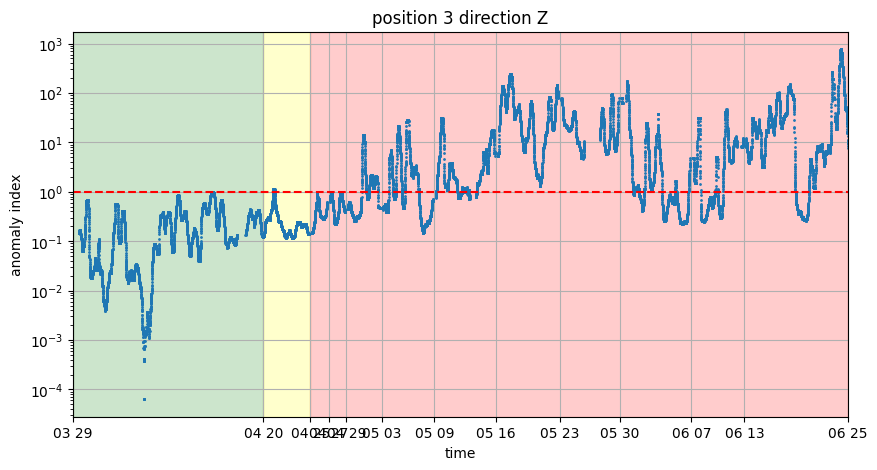

In [23]:
# now let's plot a control chart for the anomaly index per position and direction
import matplotlib.pyplot as plt

def plot_control_chart (df, pos, dir,state,xticks, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    mask = (df['position']==pos) & (df['direction']==dir)
    df_plot = df[mask]
    # moving average 
    df_plot['anomaly_index'] = df_plot['anomaly_index'].rolling(144).median()
    df_plot = scale_anomaly_index(df_plot)
    ax.plot(df_plot['time'], df_plot['anomaly_index'], 'o', markersize=1)
    ax.axhline(1, color='r', linestyle='--', markersize=1)
    ax.set_title(f'position {pos} direction {dir}')
    ax.set_ylabel('anomaly index')
    ax.set_xlabel('time')
    # background color for the 3 states (training,testing,anonmaly)
    colors= ['green', 'yellow', 'red']
    for i in range(3):
        ax.axvspan(state[i], state[i+1], alpha=0.2, color=colors[i])

    ax.grid()
    ax.set_yscale('log')
    ax.set_xticks(xticks)
    #remove year from xticks
    ax.set_xticklabels([x.strftime('%m %d') for x in xticks])
    #remove margin
    ax.margins(x=0)
    # add rms in the second y axis

    return ax
plot_control_chart(df_res, '3', 'Z',state=state,xticks=xticks)

In [145]:
from pselia.config_elia import settings
events= settings.event
events_time_abbr =dict()
for k,v in events.items():
    events_time_abbr[v['abbr']] = pd.to_datetime(v['timestamp'])
events_time_abbr['training-test'] = pd.to_datetime('2022-04-20 00:00:00')
events_time_abbr

{'training-test': Timestamp('2022-04-20 00:00:00'),
 'a': Timestamp('2022-04-25 08:05:00'),
 'b': Timestamp('2022-04-27 08:57:00'),
 'c': Timestamp('2022-04-29 09:22:00'),
 'd': Timestamp('2022-05-03 08:35:00'),
 'e': Timestamp('2022-05-09 08:05:00'),
 'f': Timestamp('2022-05-16 07:36:00'),
 'g': Timestamp('2022-05-23 12:04:00'),
 'h': Timestamp('2022-05-30 06:51:00'),
 'i': Timestamp('2022-06-07 08:09:00'),
 'j': Timestamp('2022-06-13 08:06:00')}

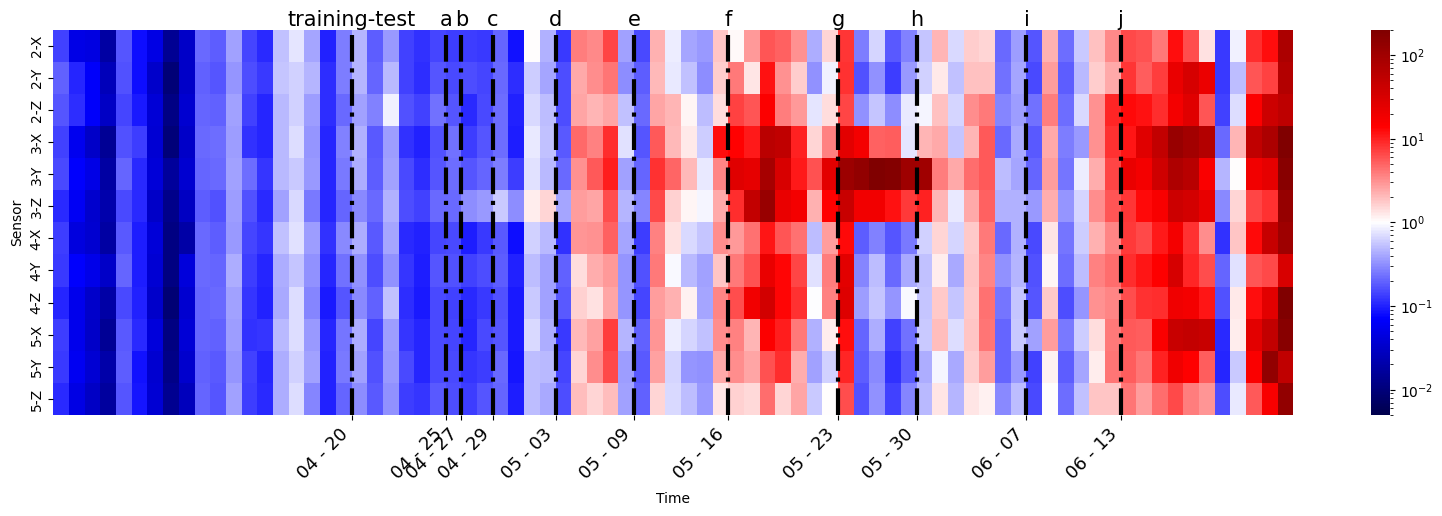

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

# Assuming df_res is your DataFrame
df_res['sensor'] = df_res['position'].astype(str) + "-" + df_res['direction']
sensors = df_res['sensor'].unique()

# DataFrame to store scaled anomaly indices
scaled_df_res = pd.DataFrame()

window_size = 288  # Define your window size for the moving average

for sensor in sensors:
    sensor_data = df_res[df_res['sensor'] == sensor]
    sensor_data = sensor_data.copy()
    
    # Apply scaling functionmean
    sensor_data = scale_anomaly_index(sensor_data)  # Assuming scale_anomaly_index is defined
    
    # Non-overlapping moving average
    sensor_data['anomaly_index'] = sensor_data['anomaly_index'].rolling(window_size,closed='right').median()
    # Drop NaN values which appear due to rolling
    sensor_data = sensor_data.dropna()
    # remove overlapping
    sensor_data = sensor_data.iloc[::window_size, :]
    
    scaled_df_res = pd.concat([scaled_df_res, sensor_data.dropna()], axis=0)  # Drop NaN values which appear due to rolling

# Pivot table for heatmapmean
heatmap_data = scaled_df_res.pivot_table(index='sensor', columns='time', values='anomaly_index')

# Define logarithmic norm with midpoint at 1
norm = LogNorm(vmin=0.005, vmax=200)  # Adjust these values as necessary


heatmap_data.columns = pd.to_datetime(heatmap_data.columns)

# Convert events_time_abbr timestamps to the same format
events_timestamps = pd.to_datetime([v for v in events_time_abbr.values()])

# Create the heatmap
fig,ax=plt.subplots(figsize=(20, 5))
sns.heatmap(heatmap_data, cmap='seismic', norm=norm,ax=ax)

# Set the title and labels
ax.set_ylabel("Sensor")
ax.set_xlabel("Time")

# Set the xticks
def find_closest_timestamp_index(timestamp, column_timestamps):
    return np.argmin(np.abs(column_timestamps - timestamp))

event_indices = [find_closest_timestamp_index(time, heatmap_data.columns) for time in events_time_abbr.values()]
abbr = list(events_time_abbr.keys())
# Set custom x-ticks and labels
ax.set_xticks(event_indices)
ax.set_xticklabels([x.strftime(' %m - %d') for x in events_time_abbr.values()], rotation=45,fontsize=13, ha='right')
# Optional: Add vertical lines for each event
for i,idx in enumerate(event_indices)S:
    ax.axvline(x=idx, color='black', linestyle='-.', linewidth=3)
    ax.text(idx, 0, abbr[i], rotation=0, fontsize=15, va='bottom', ha='center')

plt.show()



In [72]:
import numpy as np
import torch
encode_dir = {'X':0, 'Y':1, 'Z':2}
encode_pos = {'2':0, '3':1, '4':2, '5':3}
class AD_Mahalanobis():
    def __init__(self, model):
        self.model = model
        self.means = dict()
        self.cov_invs = dict()

    def fit(self, dataloader):
        features, sensors = self.load_all(dataloader)
        unique_sensors = np.unique(sensors)
        for s in unique_sensors:
            mask = sensors == s
            feature = features[mask]
            mean = np.mean(feature, axis=0)
            self.means[s] = mean
            # regularize the covariance matrix
            regularization_term = 1e-2 * np.eye(feature.shape[1])
            cov = np.cov(feature.T, bias=True) + regularization_term
            print("Condition number:", np.linalg.cond(cov))
            cov_inv = np.linalg.pinv(cov)

            self.cov_invs[s] = cov_inv


    def predict(self, data, pos, dir):
        self.model.eval()
        with torch.no_grad():
            feature,_,_ = self.model(data)
            feature = feature.detach().numpy()
        #sensor_name , pos to string, dir to string from torch tensor
        pos = pos.astype(str)
        dir = dir.astype(str)
        sensor_name = np.core.defchararray.add(pos,dir)
        
        unique_sensor = np.unique(sensor_name)
        all_mahalanobis_distance = []
        for s in unique_sensor:
            mask = sensor_name==s
            feature_sensor = feature[mask]

            mean = self.means[s]
            cov_inv = self.cov_invs[s]
            print(mean.shape, cov_inv.shape)
        
            diff = feature_sensor-mean
            print(diff.shape)
            if diff.ndim == 1:
                diff = diff.reshape(1, -1)
            print(diff.shape)
            mahalanobis_distance = np.sqrt(diff @ diff.T )
            all_mahalanobis_distance.extend(mahalanobis_distance)
        
        return all_mahalanobis_distance

    def load_all(self, dataloader):
        features = []
        sensors = []
        self.model.eval()
        with torch.no_grad():
            for batch in dataloader:
                data,pos,dir = batch
                feature, _,_ = self.model(data)
                features.append(feature.detach().numpy())
                #sensor_name , pos to string, dir to string from torch tensor
                pos = pos.numpy().astype(str)
                dir = dir.numpy().astype(str)
                # concatenate pos and dir to get sensor name element wise
                sensor_name = np.core.defchararray.add(pos,dir)
               
                sensors.append(sensor_name)
                
        return np.concatenate(features), np.concatenate(sensors)


In [132]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

class AD_CosineSimilarity():
    def __init__(self, model):
        self.model = model
        self.sensor_features = dict()  # Dictionary to store features for each sensor
        self.sensor_norms = dict()  # Dictionary to store norms for each sensor
    def fit(self, dataloader):
        features, sensors = self.load_all(dataloader)
        unique_sensors = np.unique(sensors)
        for s in unique_sensors:
            mask = sensors == s
            sensor_features = features[mask]
            self.sensor_features[s] = sensor_features
            self.sensor_norms[s] = np.linalg.norm(sensor_features, axis=1)


    def predict(self, data, pos, dir):
        self.model.eval()
        with torch.no_grad():
            features, _, _ = self.model(data)
            features = features.detach().numpy()

        sensor_names = np.core.defchararray.add(pos.astype(str), dir.astype(str))
        unique_sensors = np.unique(sensor_names)
        min_cosine_similarities = np.full(features.shape[0], np.nan)  # Use NaN for initialization

        for s in unique_sensors:
            if s in self.sensor_features:
                sensor_mask = sensor_names == s
                sensor_features = features[sensor_mask]
                sensor_training_features = self.sensor_features[s]
                sensor_training_norms = self.sensor_norms[s]

                # Compute cosine similarities for each feature in this sensor
                for i, f in enumerate(sensor_features):
                    test_vec_reshaped = f.reshape(1, -1)
                    test_vec_norm = np.linalg.norm(test_vec_reshaped)

                    # Efficient cosine similarity calculation
                    dot_product = np.dot(sensor_training_features, test_vec_reshaped.T).flatten()
                    similarities = dot_product / (sensor_training_norms * test_vec_norm)

                    # Check for empty similarities
                    if similarities.size > 0:
                        min_similarity = np.min(similarities)
                        min_cosine_similarities[sensor_mask.nonzero()[0][i]] = min_similarity

        # Replace NaNs with a default value or handle them as needed
        min_cosine_similarities = np.nan_to_num(min_cosine_similarities, nan=np.inf)

        return min_cosine_similarities

    def load_all(self, dataloader):
        features = []
        sensors = []
        self.model.eval()
        with torch.no_grad():
            for batch in dataloader:
                data, pos, dir = batch
                feature, _, _ = self.model(data)
                features.append(feature.detach().numpy())
                sensor_name = np.core.defchararray.add(pos.numpy().astype(str), dir.numpy().astype(str))
                sensors.append(sensor_name)
                
        return np.concatenate(features), np.concatenate(sensors)


In [133]:

dm.setup(return_mode_ad_system='all')
dl_feature= dm.ad_system_dataloader(batch_size=2000)

In [134]:
ad_md = AD_CosineSimilarity(model.model)
ad_md.fit(dl_feature)

In [135]:
# let's load all the data and evaluate the anomaly index and extract the latent space 
# for the original data it is in the dl_all dataloader
import pandas as pd
import torch
df_res_1 = pd.DataFrame()
model.eval()
for batch in dl_all:
    psds, pos, dir, time,state,category,rms = batch
    pos_md = np.array(pos)
    dir_md = np.array(dir)
    # encode dir to 0,1,2
    dir_md = np.array([encode_dir[d] for d in dir])
    pos_md = np.array([encode_pos[p] for p in pos])
    anomaly_index = ad_md.predict(psds, pos_md, dir_md)

    df = pd.DataFrame({'time':time,'position':pos,'direction':dir, 
                       'anomaly_index':anomaly_index, 
                       'state':state, 'category':category,'rms':rms.flatten()})    
    df_res_1 = pd.concat([df_res_1, df], axis=0)

In [136]:
df_res_1['time'] = pd.to_datetime(df_res_1['time'])

Text(0.5, 0, 'time')

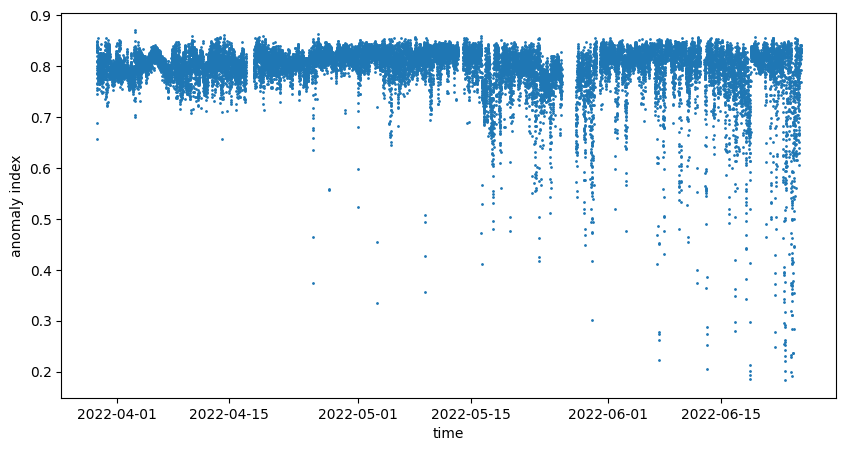

In [137]:
# select only the data for position 3 and direction Z
df_plot = df_res_1[(df_res_1['position']=='3') & (df_res_1['direction']=='Z')]
# plot the anomaly index
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_plot['time'], df_plot['anomaly_index'], 'o', markersize=1)
ax.set_ylabel('anomaly index')
ax.set_xlabel('time')
# background color for the 3 states (training,testing,anonmaly)


In [138]:
df_res_1

,time,position,direction,anomaly_index,state,category,rms
0,2022-03-29 12:00:00,2,X,0.876902,training,start_measurements,0.028605
1,2022-03-29 12:00:00,2,Y,0.880148,training,start_measurements,0.986604
2,2022-03-29 12:00:00,2,Z,0.868180,training,start_measurements,0.981312
3,2022-03-29 12:00:00,3,X,0.889457,training,start_measurements,0.000522
4,2022-03-29 12:00:00,3,Y,0.765430,training,start_measurements,0.999225
...,...,...,...,...,...,...,...
1803,2022-06-25 00:05:00,4,Y,0.833874,anomaly,Reinforcement_EW916,0.996932
1804,2022-06-25 00:05:00,4,Z,0.833692,anomaly,Reinforcement_EW916,0.062626
1805,2022-06-25 00:05:00,5,X,0.672462,anomaly,Reinforcement_EW916,0.011289
1806,2022-06-25 00:05:00,5,Y,0.846953,anomaly,Reinforcement_EW916,0.989735


/tmp/ipykernel_11186/161710509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['anomaly_index'] = df_plot['anomaly_index'].rolling(1).median()
/tmp/ipykernel_11186/2860632618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sys['anomaly_index'] = -df_sys['anomaly_index']
/tmp/ipykernel_11186/2860632618.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<Axes: title={'center': 'position 3 direction Z'}, xlabel='time', ylabel='anomaly index'>

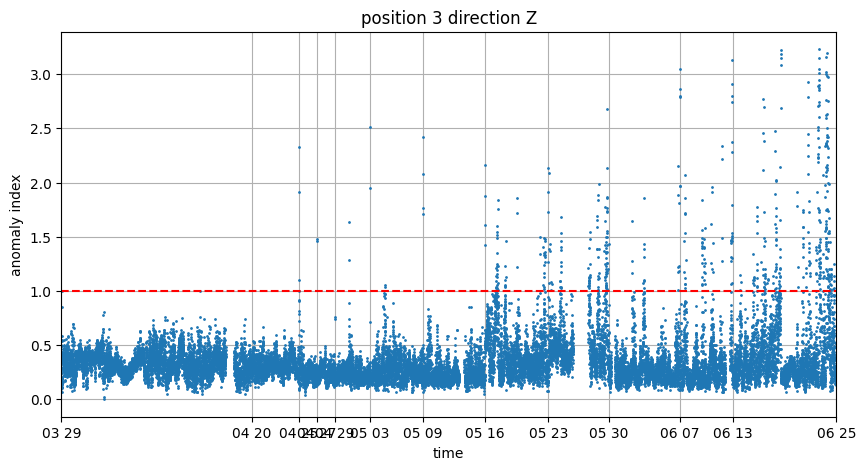

In [140]:
# now let's plot a control chart for the anomaly index per position and direction
import matplotlib.pyplot as plt

def plot_control_chart (df, pos, dir,state,xticks, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    mask = (df['position']==pos) & (df['direction']==dir)
    df_plot = df[mask]
    # moving average 
    df_plot['anomaly_index'] = df_plot['anomaly_index'].rolling(1).median()
    df_plot = scale_anomaly_index(df_plot)
    ax.plot(df_plot['time'], df_plot['anomaly_index'], 'o', markersize=1)
    ax.axhline(1, color='r', linestyle='--', markersize=1)
    ax.set_title(f'position {pos} direction {dir}')
    ax.set_ylabel('anomaly index')
    ax.set_xlabel('time')
    # background color for the 3 states (training,testing,anonmaly)
    colors= ['green', 'yellow', 'red']


    ax.grid()
    ax.set_xticks(xticks)
    #remove year from xticks
    ax.set_xticklabels([x.strftime('%m %d') for x in xticks])
    #remove margin
    ax.margins(x=0)
    # add rms in the second y axis

    return ax
plot_control_chart(df_res_1, '3', 'Z',state=state,xticks=xticks)

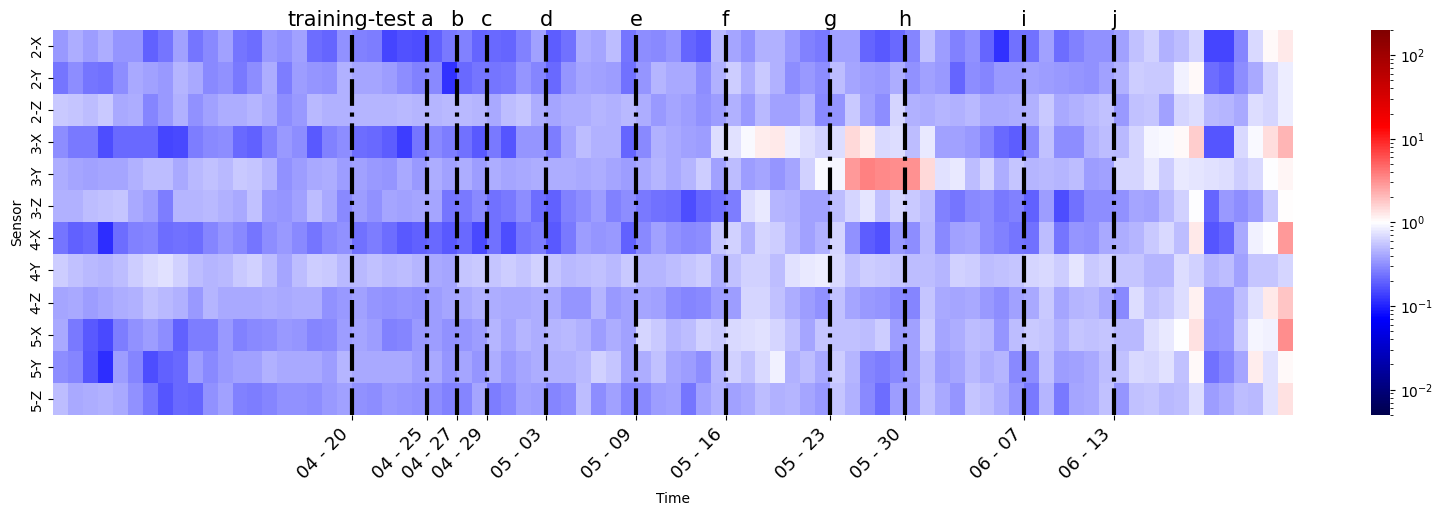

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

# Assuming df_res is your DataFrame
df_res_1['sensor'] = df_res_1['position'].astype(str) + "-" + df_res_1['direction']
sensors = df_res_1['sensor'].unique()

# DataFrame to store scaled anomaly indices
scaled_df_res = pd.DataFrame()

window_size = 288  # Define your window size for the moving average

for sensor in sensors:
    sensor_data = df_res_1[df_res_1['sensor'] == sensor]
    sensor_data = sensor_data.copy()
    
    # Apply scaling functionmean
    sensor_data = scale_anomaly_index(sensor_data)  # Assuming scale_anomaly_index is defined
    
    # Non-overlapping moving average
    sensor_data['anomaly_index'] = sensor_data['anomaly_index'].rolling(window_size,closed='right').median()
    # Drop NaN values which appear due to rolling
    sensor_data = sensor_data.dropna()
    # remove overlapping
    sensor_data = sensor_data.iloc[::window_size, :]
    
    scaled_df_res = pd.concat([scaled_df_res, sensor_data.dropna()], axis=0)  # Drop NaN values which appear due to rolling

# Pivot table for heatmapmean
heatmap_data = scaled_df_res.pivot_table(index='sensor', columns='time', values='anomaly_index')

# Define logarithmic norm with midpoint at 1
norm = LogNorm(vmin=0.005, vmax=200)  # Adjust these values as necessary


heatmap_data.columns = pd.to_datetime(heatmap_data.columns)

# Convert events_time_abbr timestamps to the same format
events_timestamps = pd.to_datetime([v for v in events_time_abbr.values()])

# Create the heatmap
fig,ax=plt.subplots(figsize=(20, 5))
sns.heatmap(heatmap_data, cmap='seismic', norm=norm,ax=ax)

# Set the title and labels
ax.set_ylabel("Sensor")
ax.set_xlabel("Time")

# Set the xticks
def find_closest_timestamp_index(timestamp, column_timestamps):
    return np.argmin(np.abs(column_timestamps - timestamp))

event_indices = [find_closest_timestamp_index(time, heatmap_data.columns) for time in events_time_abbr.values()]
abbr = list(events_time_abbr.keys())
# Set custom x-ticks and labels
ax.set_xticks(event_indices)
ax.set_xticklabels([x.strftime(' %m - %d') for x in events_time_abbr.values()], rotation=45,fontsize=13, ha='right')
# Optional: Add vertical lines for each event
for i,idx in enumerate(event_indices):
    ax.axvline(x=idx, color='black', linestyle='-.', linewidth=3)
    ax.text(idx, 0, abbr[i], rotation=0, fontsize=15, va='bottom', ha='center')

plt.show()



In [105]:
df_res_1

,time,position,dmaxirection,anomaly_index,state,category,rms,sensor
0,2022-03-29 12:00:00,2,X,0.770003,training,start_measurements,0.028605,2-X
1,2022-03-29 12:00:00,2,Y,0.770003,training,start_measurements,0.986604,2-Y
2,2022-03-29 12:00:00,2,Z,0.770003,training,start_measurements,0.981312,2-Z
3,2022-03-29 12:00:00,3,X,0.770003,training,start_measurements,0.000522,3-X
4,2022-03-29 12:00:00,3,Y,0.770003,training,start_measurements,0.999225,3-Y
...,...,...,...,...,...,...,...,...
1803,2022-06-25 00:05:00,4,Y,0.109284,anomaly,Reinforcement_EW916,0.996932,4-Y
1804,2022-06-25 00:05:00,4,Z,0.109284,anomaly,Reinforcement_EW916,0.062626,4-Z
1805,2022-06-25 00:05:00,5,X,0.109284,anomaly,Reinforcement_EW916,0.011289,5-X
1806,2022-06-25 00:05:00,5,Y,0.109284,anomaly,Reinforcement_EW916,0.989735,5-Y
